# CISC 451/839 Topics in Data Analytics 
## Assignment 3 - Customer Segmentation for Online Retail Using Unsupervised Learning 
### Gavin McClelland - 10211444 
### Marshall Cunningham - 20249991

The objectives of this notebook are as follows: 
- to segment customers into meaningful clusters using unsupervised learning in conjunction with the Recency, Frequency, and Monetary (RFM) model
- Identify the main characteristics of the consumers in each customer segment 

Detailed statistics, distinct features, and distribution of customers within each cluster will be analyzed in this notebook, but will be discussed in further detail in the accompanying report

## Contents

The analytics process contained in this notebook is as follows:

1. Basic Data Acquisition (from provided dataset)
2. Data Preparation (feature engineering and selection)
- Developing an RFM model using the provided dataset
3. Unsupervised Learning
4. Model Optimization and Selection

In [100]:
import pandas as pd 
import numpy as np 
%cd "C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\a3"

C:\Users\gmcclelland\Desktop\Misc School Stuff\repo\CISC451\a3


In [101]:
df = pd.read_excel('data/Online Retail.xlsx')

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [103]:
# Get percentage of null records
percent_missing = (df.isnull().sum()/len(df))*100

# Get count of records missing
missing_count = df.isnull().sum()
print(f'''Number of records missing:\n {missing_count} n\n\n\n Percent Missing:\n{percent_missing}''')

Number of records missing:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64 n


 Percent Missing:
InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


From the above, we can see that most records are populated, so let's briefly explore the records with a NULL CustomerID

In [104]:
df.CustomerID.nunique()

4372

<AxesSubplot:xlabel='Country'>

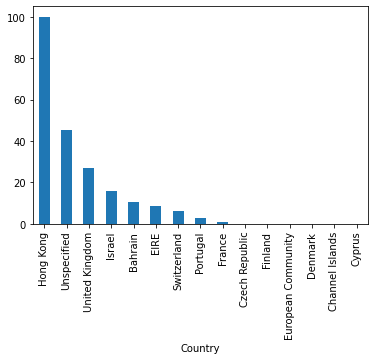

In [105]:
# There are 4372 unique customers, and one of those unique identifiers is null. Let's explore the records with this value a bit further

df['null_cust'] = np.where(df.CustomerID.isnull(),1,0)

# percentage of null values by country
((df.groupby(['Country'])['null_cust'].sum()/df.groupby(['Country']).size())*100).sort_values(ascending=False).head(15).plot(kind='bar')

In [106]:
((df.groupby(['Country'])['null_cust'].sum()/df.groupby(['Country']).size())*100).sort_values(ascending=False).head(15)

Country
Hong Kong             100.000000
Unspecified            45.291480
United Kingdom         26.963861
Israel                 15.824916
Bahrain                10.526316
EIRE                    8.674963
Switzerland             6.243756
Portugal                2.567479
France                  0.771298
Czech Republic          0.000000
Finland                 0.000000
European Community      0.000000
Denmark                 0.000000
Channel Islands         0.000000
Cyprus                  0.000000
dtype: float64

### Basic Data Cleaning
Removing NULLs, and negatives where there shouldn't be

In [107]:
# Lets find all records where quantities or prices are negative
df.loc[((df.Quantity < 0) | (df.UnitPrice < 0)) & (df.CustomerID.notnull())].shape[0]


8905

In [108]:
# Assume that these are items that have been returned and hence, negative revenue
# This makes more sense seeing that there are no records with both a negative UnitPrice AND Quantity
df.loc[(df.Quantity < 0) & (df.UnitPrice < 0)].shape[0]

0

In [109]:
# This is made more clear by the description of the two records where prices are negative, and also for records with descriptions like "Missing", "lost", or "MIA"
neg_prices = df.loc[df.UnitPrice < 0]

some_neg_quantities = df.loc[(df.Description == 'Missing') | (df.Description == 'lost') |(df.Description == 'MIA')]

display(neg_prices,some_neg_quantities)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,null_cust
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,1
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,null_cust
112036,545857,20681,MIA,-154,2011-03-07 13:56:00,0.0,NaN,United Kingdom,1
165448,550800,22458,Missing,-65,2011-04-20 14:48:00,0.0,NaN,United Kingdom,1
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,1


So, with null values identified, the only cleaning that needs to be done is to remove records with a NULL CustomerID. This removes ~25% of the records from the provided dataset, but this will leave us with a sufficient number of records for analyses. Let's deal with this next.

In [110]:
df = df[df.CustomerID.notnull()]

In [111]:
df.shape[0]

406829

### Creation an RFM representation 
Now that some basic preprocessing has taken place, it is time to employ the hints specified in the assignment outline, which are as follows:

- Group same customer transactions (multiple records for same customer) into a single record (one record per customer).
- Create the three aggregated variables Recency, Frequency and Monetary (Sum, Min, Median, Max) for each customer.
    - Recency: Number of months between the last order and the last date of the study (09/12/2011). Zero is most recent.
    - Frequency: Number of orders made in the study period (Count transactions per customer).
    - Monetary: Money value for the purchases per customer.
- Handle outliers since clustering algorithms can be sensitive to outliers or variables that are of incomparable scales or magnitudes. Perhaps we will use K-Medians to mitigate this instead of K-Means.
        - Outliers should be isolated from the majority and treated separately.
- Incomparable scales variables should be normalized before the clustering analysis.

In [112]:
# First, some simple things:

# Create a TotalPrice feature for each record as a product of quantity and number of units
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Calculate most recent date that a transaction occurred, this logic will be used for each customer to resolve the 'Recency' metric
import datetime as dt 
most_recent = df.InvoiceDate.max() + dt.timedelta(days=1) # Used for recency

In [113]:
rec_freq_mon = df.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x : (most_recent - x.max()).days,
    'InvoiceNo':'count',
    'TotalPrice':['sum','min','max','mean','median']
})

rec_freq_mon.rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalPrice':'Monetary'
}, inplace=True)

In [114]:
rec_freq_mon.head()

Recency Frequency Monetary                                     
           <lambda>     count      sum       min      max       mean median
CustomerID                                                                 
12346.0         326         2     0.00 -77183.60  77183.6   0.000000   0.00
12347.0           2       182  4310.00      5.04    249.6  23.681319  17.00
12348.0          75        31  1797.24     13.20    240.0  57.975484  41.76
12349.0          19        73  1757.55      6.64    300.0  24.076027  17.70
12350.0         310        17   334.40      8.50     40.0  19.670588  19.80

Now that each RFM metric has been created (with a few additional monetary statistics), these values can be quantized (or binned) and assigned a corresponding label from 1 to 5. Then, each customer can be assigned an RFM score, with 5+5+5=15 being ideal.

In [115]:
rec_scores = range(5,0,-1)
other_scores = range(1,6)
rec_freq_mon['R'] = pd.qcut(rec_freq_mon.Recency['<lambda>'],q=5,labels=rec_scores)
rec_freq_mon['F'] = pd.qcut(rec_freq_mon.Frequency['count'],q=5,labels=other_scores)
rec_freq_mon['M_sum'] = pd.qcut(rec_freq_mon.Monetary['sum'],q=5,labels=other_scores)
rec_freq_mon['M_min'] = pd.qcut(rec_freq_mon.Monetary['min'],q=5,labels=other_scores)
rec_freq_mon['M_max'] = pd.qcut(rec_freq_mon.Monetary['max'],q=5,labels=other_scores)
rec_freq_mon['M_mean'] = pd.qcut(rec_freq_mon.Monetary['mean'],q=5,labels=other_scores)
rec_freq_mon['M_median'] = pd.qcut(rec_freq_mon.Monetary['median'],q=5,labels=other_scores)

# Find median of the labels assigned to each 
i = rec_freq_mon[['M_sum','M_min','M_max','M_mean','M_median']]
i['M'] = i.mean(axis=1)
# rec_freq_mon['RFM'] = rec_freq_mon[['']]
rec_freq_mon['M'] = pd.qcut(i['M'],q=5,labels=other_scores)

In [116]:
rec_freq_mon['RFM_score'] = rec_freq_mon[['R','F','M']].sum(axis=1)
rec_freq_mon.sort_values('RFM_score',ascending=False)

Recency Frequency  Monetary                                  \
           <lambda>     count       sum       min       max        mean   
CustomerID                                                                
15290.0           5       212   7803.77    -71.70    149.76   36.810236   
12490.0           5       245   5417.93      4.56    171.84   22.114000   
14282.0           3       156   3729.34      2.34    179.00   23.906026   
14422.0           1       222   4263.64      2.88     83.40   19.205586   
17677.0           2       321  16219.22    -24.90    249.00   50.527165   
...             ...       ...       ...       ...       ...         ...   
16349.0         291         9     53.50      0.42     15.95    5.944444   
14046.0         284        14    154.99      2.10     40.32   11.070714   
17217.0         234         9    113.50      0.95     65.45   12.611111   
12666.0         359         2   -227.44   -136.00    -91.44 -113.720000   
12346.0         326         2      0.00 -77183.60  77183.60    0.000000   

                    R  F M_sum M_min M_max M_mean M_median  M RFM_score  
            median                                                       
CustomerID                                                               
15290.0      30.60  5  5     5     1     5      5        5  5        15  
12490.0      17.70  5  5     5     4     5      4        4  5        15  
14282.0      17.00  5  5     5     3     5      4        4  5        15  
14422.0      17.00  5  5     5     4     4      4        4  5        15  
17677.0      17.40  5  5     5     1     5      5        4  5        15  
...            ... .. ..   ...   ...   ...    ...      ... ..       ...  
16349.0       2.55  1  1     1     3     1      1        1  1         3  
14046.0       6.90  1  1     1     3     2      2        2  1         3  
17217.0       3.95  1  1     1     3     3      2        1  1         3  
12666.0    -113.72  1  1     1     1     1      1        1  1         3  
12346.0       0.00  1  1     1     1     5      1        1  1         3  

[4372 rows x 16 columns]

<AxesSubplot:xlabel='RFM_score'>

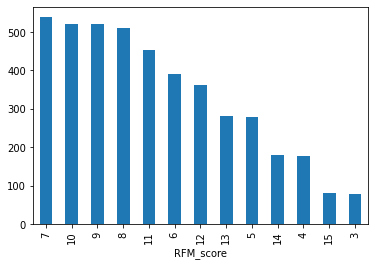

In [117]:
rec_freq_mon.groupby(['RFM_score']).size().sort_values(ascending=False).plot(kind='bar')

In [135]:
from scipy import stats
z = np.abs(stats.zscore(rec_freq_mon))


In [138]:
outlier_corrected_RFM = rec_freq_mon[(z<=3).all(axis=1)]

In [139]:
outlier_corrected_RFM.shape[0]

4290

In [140]:
rec_freq_mon.shape[0]

4372